# Imports

In [35]:
import os
import sys
import time
import re
import pickle
import logging
import string
import warnings
import math

import pandas as pd
import numpy as np
import pylab
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import nltk
import nltk.data
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score as AUC

import gensim
from gensim import corpora
from gensim import models
from gensim import similarities
from gensim.models import Word2Vec

from bs4 import BeautifulSoup
from sklearn.metrics import log_loss

%matplotlib inline

# Get Data

In [6]:
nltk.download("stopwords")
quora_train = pd.read_csv("data/train.csv")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thiagocunha/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
print (type(quora_train))
print(quora_train.head())

<class 'pandas.core.frame.DataFrame'>
   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  


In [17]:
sum(quora_train['is_duplicate'] == quora_train['is_duplicate'])

404288

In [18]:
len(quora_train)

404288

# Functions to process data

In [8]:
# Editing questions with NLTK package

def remove_stopwords(phrase,list_stopwords):
    """
    Receives a phrase and removes all stopwords from a list
    :param phrase: String. A phrase.
    :param list_stopwords: List. A list of stopwords
    :return: The same phrase without stopwords
    """
    final_phrase = []
    words = phrase.split(" ")
    for word in words:
        if word not in list_stopwords:
            final_phrase.append((word))
    
    final_phrase = ' '.join(final_phrase)
    
    return final_phrase
    
def remove_punctuation(phrase):
    """
    Receives a phrase and removes all punctuation from it
    :param phrase: String. A phrase.
    :return: The same phrase without punctuation
    """
    #Check if NA
    if type(phrase) is float:
        if math.isnan(phrase):
            return ("")
    
    translator = str.maketrans('', '', string.punctuation)
    phrase = phrase.translate(translator) #removing punctuation
        
    return phrase

def lemm_wordnet(phrase):
    """
    Receives a phrase and removes lemmatizes it
    :param phrase: String. A phrase.
    :return: The same phrase in lemmas
    """
    lemm = WordNetLemmatizer()
    
    #NA is a float type, so this if is to avoid conflict
    if type(phrase) is not float:
        phrase = [lemm.lemmatize(i) for i in phrase.split()]
        phrase = ' '.join(phrase)
    else:
        return ""
    return phrase
    
def remove_duplicate(phrase):
    """
    Receives a phrase and removes all duplicate words
    :param phrase: String. A phrase.
    :return: The same phrase with just unique words
    """
    aux_phrase = []
        
    if type(phrase) is not float:
        
        for i in phrase.split():
            
            if i not in aux_phrase:
                aux_phrase.append(i)
    
    phrase = ' '.join(aux_phrase)
    
    return phrase
    
    
def all_lower_case(phrase):    
    """
    Receives a phrase and makes it lower case
    :param phrase: String. A phrase.
    :return: The same phrase in lower case
    """
    if type(phrase) is not float:
            phrase = phrase.lower()
    return phrase
    
def stem_snowball(phrase):
    """
    Receives a phrase and returns the same phrase stemmed, lowercase phrase without stopwords
    :param phrase: String. A phrase.
    :return: String. Stemmed, lowercase phrase without stopwords
    """
    stemmer = SnowballStemmer("english")
    
    #Stem words according to stemmer
    final_phrase = []
    words = phrase.split(" ")
    for word in words:
        final_phrase.append((stemmer.stem(word)))
    
    final_phrase = ' '.join(final_phrase)
    
    return final_phrase

stem_snowball("What is the step by step guide to invest in share market in india?")

#This function will return a Bag of words of our two questions using TF method
def vectorizer_tf(data, features = 5000):
    """
    Receives the data frame. Merges all words in question1 and question2 and vectorizes with tf algorithm.
    :param phrase: data frame.
    :param features: number of features for the vectorizes.
    :return: An array with #number of features
    """
    vectorizer_count = CountVectorizer(ngram_range=(1, 2), max_features = features)
    
    merge = data.question1.append([data.question2])
    
    vector_fitt = vectorizer_count.fit(merge)
    
    question1 = vector_fitt.transform(data.question1)
    question2 = vector_fitt.transform(data.question2)
    
    question1 = question1.toarray()
    question2 = question2.toarray()
    
    return question1 + question2

#This function will return a Bag of words of our two questions using TF-idf method

def vectorizer_tf_idf(data, features = 5000):
    """
    Receives the data frame. Merges all words in question1 and question2 and vectorizes with tf-idf algorithm.
    :param data: data frame.
    :param features: number of features for the vectorizes.
    :return: An array with #number of features
    """
    vectorizer_tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features = features, sublinear_tf=True)
    
    merge = data.question1.append([data.question2])
    
    vector_tf_idf_fitt = vectorizer_tf_idf.fit(merge)
    
    question1 = vector_tf_idf_fitt.transform(data.question1)
    question2 = vector_tf_idf_fitt.transform(data.question2)
        
    question1 = question1.toarray()
    question2 = question2.toarray()
    
    return question1 + question2

In [9]:
#cleaning tool is used so you can easily choose which functions you want to use to clean te text
def cleaning_tool(data, drop_na = True, lower_case = True, rm_duplicate = False, stopwords = False, 
                  punctuation = False, lemm = False, stem = False, list_of_stopwords = None):
    """
    Function to process all data using calling functions from above, according to what was chosen.
    :param data: data frame.
    :param drop_na: If True drop all lines of data frame with NA
    :param lower_case: If True transform for lower case
    :param rm_duplicate: If True remove all duplicate words in questions
    :param stopwords: If True removes stopwords
    :param punctuation: If True removes punctuation
    :param lemm: If True returns the phrase lemmatized
    :param stem: If True returns the phrase stemmed
    :param list_of_stopwords: List of stopwords to be used
    :return: Question1 and Question2 processed according to parameters
    """
    if drop_na == True:
        data = data.dropna(0)
    
    if rm_duplicate == True:
        data["question1"] = data["question1"].apply(lambda x: remove_duplicate(x))
        data["question2"] = data["question2"].apply(lambda x: remove_duplicate(x))
    
    if lower_case == True:
        data["question1"] = data["question1"].apply(lambda x: all_lower_case(x))
        data["question2"] = data["question2"].apply(lambda x: all_lower_case(x))
    
    if stopwords == True:
        data["question1"] = data["question1"].apply(lambda x: remove_stopwords(x, list_of_stopwords))
        data["question2"] = data["question2"].apply(lambda x: remove_stopwords(x, list_of_stopwords))
       
    if punctuation == True:
        data["question1"] = data["question1"].apply(lambda x: remove_punctuation(x))
        data["question2"] = data["question2"].apply(lambda x: remove_punctuation(x))
        
    if lemm_wordnet == True:
        data["question1"] = data["question1"].apply(lambda x: lemm_wordnet(x))
        data["question2"] = data["question2"].apply(lambda x: lemm_wordnet(x))
        
    if stem_snowball == True:
        data["question1"] = data["question1"].apply(lambda x: stem_snowball(x))
        data["question2"] = data["question2"].apply(lambda x: stem_snowball(x))
    
    #We used it two times if some function create a new NA.
    if drop_na == True:
        data = data.dropna(0)    
        
    return data

# Cleaning Quora Train

In [10]:
quora_train = cleaning_tool(quora_train, lemm = True, rm_duplicate = True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

# Bag of Words

In [ ]:
#quora_train = quora_train.head(5000)

In [ ]:
#https://en.wikipedia.org/wiki/Tf%E2%80%93idf
    
quora_train_tf = vectorizer_tf(quora_train, features = 500)

In [ ]:
quora_train_tf_idf = vectorizer_tf_idf(quora_train, features = 500)

# Store edited databases w/ Pickle

In [ ]:
fileObject = open("Edited_Base_stem_stopwords",'wb') 
pickle.dump(quora_train,fileObject)  
fileObject.close()

In [ ]:
fileObject = open("Edited_Base_stem_stopwords",'rb')  
quora_train = pickle.load(fileObject)

# Split data into training/testing

In [ ]:
'''
The function train_test_split transform your databse in 4 parts, 
the first one is the new "train" database without the independent variable, 
the second one is the new test database without the independent variable,
the third one is just the independent variable from the first part and
the fourht one is just the independent variable from the second part.
'''

quora_train_features_tf, quora_test_features_tf, quora_train_y_tf, quora_test_y_tf = model_selection.train_test_split(
    quora_train_tf, quora_train['is_duplicate'], test_size = 0.3, random_state = 0)

In [ ]:
quora_train_features_tf_idf, quora_test_features_tf_idf, quora_train_y_tf_idf, quora_test_y_tf_idf = model_selection.train_test_split(
    quora_train_tf_idf, quora_train['is_duplicate'], test_size = 0.3, random_state = 0)

# Exploratory Data Analysis

In [ ]:
def calculate_common_percentage(df):
    """
    Receives the initial data frame and adds  the colunms "num_words_common", "num_words_total" and "common_percentage"
    :param package_name: Data frame train.csv from the Kaggle website
    :return: Data frame with added colunms "num_words_common", "num_words_total" and "common_percentage"
    """
    num_words_common = []
    num_words_total = []

    for line in range(0,len(df)):
        count_total = 0
        count_common = 0
        for word in df["question1_edited"][line].split(" "):
            if word in df["question2_edited"][line]:
                count_common = count_common+1
            count_total = count_total+1
        num_words_common.append(count_common) 
        num_words_total.append(count_total)

    num_words_common = pd.Series(num_words_common)
    num_words_total = pd.Series(num_words_total)

    df["num_words_common"] = num_words_common.values
    df["num_words_total"] = num_words_total.values
    df["common_percentage"] = df["num_words_common"]/df["num_words_total"]

    return (df)

In [ ]:
quora_train = calculate_common_percentage(quora_train)
#"num_words_common", "num_words_total" and "common_percentage"
plt.figure()
#plt.boxplot(quora_train["common_percentage"],quora_train["is_duplicate"])


quora_train.boxplot(column='common_percentage', by='is_duplicate')
plt.suptitle('')

axes = plt.gca()
axes.set_ylim([-0.2,1.1])
plt.title("Common word percentage and is_duplicate")

plt.show()

# Learning Models

## Random Forest

In [ ]:
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier

randomforest_tf = RandomForestClassifier(n_estimators=300, max_features='auto', bootstrap=False, 
                               oob_score=False, n_jobs=-1, random_state=0).fit(quora_train_features_tf, quora_train_y_tf)

In [ ]:
randomforest_tf_score = randomforest_tf.score(quora_test_features_tf, quora_test_y_tf)
print(randomforest_tf_score)

In [ ]:
predict_tf = randomforest_tf.predict_proba(quora_test_features_tf)

In [ ]:
log_loss(quora_test_y_tf,predict_tf)

In [ ]:
randomforest_tf_idf = RandomForestClassifier(n_estimators=300, max_features='auto', bootstrap=False, 
                               oob_score=False, n_jobs=-1, random_state=0).fit(quora_train_features_tf_idf, quora_train_y_tf_idf)

In [ ]:
randomforest_tf_score_idf = randomforest_tf_idf.score(quora_test_features_tf_idf, quora_test_y_tf_idf)
print(randomforest_tf_score)

In [ ]:
predict_tf_idf = randomforest_tf_idf.predict_proba(quora_test_features_tf_idf)

In [ ]:
log_loss(quora_test_y_tf,predict_tf)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression as LR

clf_LR_tf = LR(penalty='l2',
               dual=False,
               tol=0.0001,
               C=1.0,
               fit_intercept=True,
               intercept_scaling=1,
               class_weight=None,
               random_state=0,
               solver='liblinear',
               max_iter=100,
               multi_class='ovr',
               verbose=0).fit(quora_train_features_tf, quora_train_y_tf)

eval_LR_tf_tts = clf_LR_tf.score(quora_test_features_tf, quora_test_y_tf)
print(eval_LR_tf_tts)
predict_tf = clf_LR_tf.predict_proba(quora_test_features_tf)
log_loss(quora_test_y_tf,predict_tf)

In [ ]:
clf_LR_tfidf = LR(penalty='l2',
                  dual=False,
                  tol=0.0001,
                  C=1.0,
                  fit_intercept=True,
                  intercept_scaling=1,
                  class_weight=None,
                  random_state=0,
                  solver='liblinear',
                  max_iter=100,
                  multi_class='ovr',
                  verbose=0).fit(quora_train_features_tf_idf, quora_train_y_tf_idf)

eval_LR_tf_idf_tts = clf_LR_tfidf.score(quora_test_features_tf_idf, quora_test_y_tf_idf)
print(eval_LR_tf_idf_tts)
predict_tf_idf = clf_LR_tf.predict_proba(quora_test_features_tf_idf)
log_loss(quora_test_y_tf_idf,predict_tf_idf)

## Gradient Boost

## Cross-Validation

In [19]:
models = []
accuracy = []

#### Model: Random-Forest

In [ ]:
#set external parameters
    model_name = 'Random-Forest'
    k = 10
    data = quora_train
    output_name = 'is_duplicate'
    
#reset internal parameters
    n = len(data)
    total_accuracy = 0
    
#i-fold validation
    for i in range(0, k):
        start = (n*i)/k
        end = (n*(i+1))/k-1
        
    #split training anda validation set
        validation_set = data[start:end+1]
        
        if i == 0:
            training_set = data[end+1:n+1]
            
        elif i == k-1:
            training_set = data[0:start]
        else:
            training_set_part1 = data[0:start]
            training_set_part2 = data[end+1:n+1]
            training_set = training_set_part1.append(training_set_part2)
        
        
    #model training
        trained_model = #graphlab.linear_regression.create(training_set, target = output_name, features = features_list,
                                                  #validation_set = None, l2_penalty = l2_penalty)
        
    #calculate accuracy of the model

        predictions = #trained_model.predict(validation_set)

        total_accuracy += sum(validation_set[output_name] == predictions)/len(validation_set)        

    
#record the result
    models.append(model_name)
    accuracy.append(total_accuracy/k)
    
        

#### Models Overview

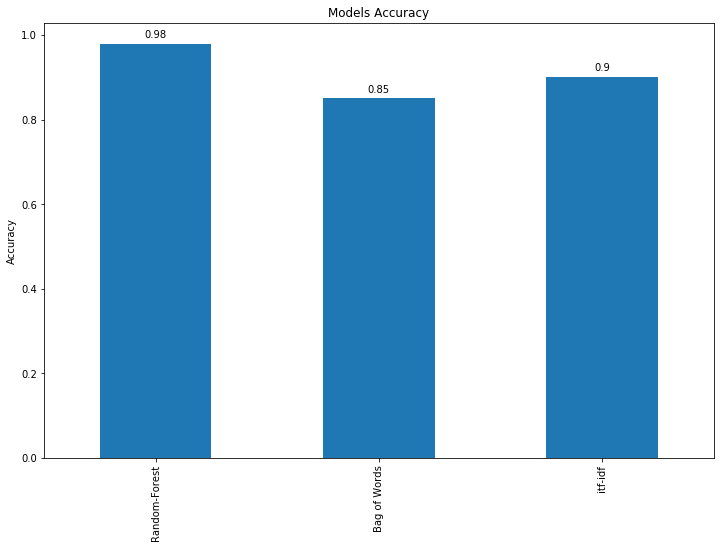

In [49]:
accuracy_series = pd.Series.from_array(accuracy) 
x_labels = models 

# now to plot the figure...
plt.figure(figsize=(12, 8))
ax = accuracy_series.plot(kind='bar')
ax.set_title("Models Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xticklabels(x_labels)

rects = ax.patches

# Now make some labels
labels = accuracy

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.01 , label, ha='center', va='bottom')
    